# Experimental results

In this notebook, we analyze the experimental results from the following problems:
- **P1**: Second autocorrelation inequality (AlphaEvolve's B2) 
- **P2**: Minimizing the ratio of maximum to minimum distance (AlphaEvolve's B8) 
- **P3**: Packing circles inside a unit square to maximize sum of radii (AlphaEvolve's B12) 
- **P4**: Packing circles inside a rectangle of perimeter 4 to maximize sum of radii (AlphaEvolve's B13)  

## Imports and auxiliary functions

In [1]:
import sys

sys.path.insert(0, "../")

import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy as sp

from data_analysis_utils.processing_utils import process_experiments, get_experiment_sol

## Results

In [2]:
model_names = ["GOOGLE_GEMINI-2.5-FLASH", "GOOGLE_GEMINI-2.5-PRO"]
model2cost = {
    "GOOGLE_GEMINI-2.5-FLASH": {"prompt_pm": 0.3, "compl_pm": 2.5},
    "GOOGLE_GEMINI-2.5-PRO": {"prompt_pm": 2.5, "compl_pm": 12.5},
}

results_df_rows = {}

os.makedirs("figs/", exist_ok=True)

### P1

In [3]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def verify_p1(sol):
    """ """
    convolution_2 = np.convolve(sol, sol)
    num_points = len(convolution_2)
    x_points = np.linspace(-0.5, 0.5, num_points + 2)
    x_intervals = np.diff(x_points)
    y_points = np.concatenate(([0], convolution_2, [0]))
    l2_norm_squared = 0.0
    for i in range(len(convolution_2) + 1):
        y1 = y_points[i]
        y2 = y_points[i + 1]
        h = x_intervals[i]
        interval_l2_squared = (h / 3) * (y1**2 + y1 * y2 + y2**2)
        l2_norm_squared += interval_l2_squared

    norm_1 = np.sum(np.abs(convolution_2)) / (len(convolution_2) + 1)

    norm_inf = np.max(np.abs(convolution_2))
    C_lower_bound = l2_norm_squared / (norm_1 * norm_inf)

    print(f"This step function shows that C2 >= {C_lower_bound}")
    return C_lower_bound

def plot_step_function(
    step_heights_input: list[float], title="", figsize=(4, 3), save_path=None
):
    """Plots a step function with equally-spaced intervals on [-1/4,1/4]."""
    num_steps = len(step_heights_input)

    step_edges_plot = np.linspace(-0.25, 0.25, num_steps + 1)
    x_plot = np.array([])
    y_plot = np.array([])

    for i in range(num_steps):
        x_start = step_edges_plot[i]
        x_end = step_edges_plot[i + 1]
        x_step_vals = np.linspace(x_start, x_end, 100)
        y_step_vals = np.full_like(x_step_vals, step_heights_input[i])
        x_plot = np.concatenate((x_plot, x_step_vals))
        y_plot = np.concatenate((y_plot, y_step_vals))

    fig = plt.figure(figsize=figsize)
    plt.plot(x_plot, y_plot)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(title)
    plt.xlim([-0.3, 0.3])
    plt.ylim([-1, max(step_heights_input) * 1.2])
    plt.grid(True)
    plt.step(
        step_edges_plot[:-1],
        step_heights_input,
        where="post",
        color="green",
        linewidth=2,
        label=f"steps = {num_steps}",
    )

    if save_path:
        plt.savefig(save_path, dpi=fig.dpi, bbox_inches="tight")
    plt.legend(loc="upper left")
    plt.show()


def plot_two_step_functions(
    step_heights_1: list[float],
    step_heights_2: list[float],
    title_1="Solution 1",
    title_2="Solution 2",
    figsize=(12, 5),
    save_path=None,
):
    """Plots two step functions with equally-spaced intervals on [-1/4,1/4] as subplots."""

    def generate_step_plot_data(step_heights_input):
        """Helper function to generate x and y data for plotting step function."""
        num_steps = len(step_heights_input)
        step_edges_plot = np.linspace(-0.25, 0.25, num_steps + 1)
        x_plot = np.array([])
        y_plot = np.array([])
        for i in range(num_steps):
            x_start = step_edges_plot[i]
            x_end = step_edges_plot[i + 1]
            x_step_vals = np.linspace(x_start, x_end, 100)
            y_step_vals = np.full_like(x_step_vals, step_heights_input[i])
            x_plot = np.concatenate((x_plot, x_step_vals))
            y_plot = np.concatenate((y_plot, y_step_vals))
        return x_plot, y_plot, step_edges_plot

    x_plot_1, y_plot_1, step_edges_1 = generate_step_plot_data(step_heights_1)
    x_plot_2, y_plot_2, step_edges_2 = generate_step_plot_data(step_heights_2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)

    ax1.plot(x_plot_1, y_plot_1)
    ax1.step(step_edges_1[:-1], step_heights_1, where="post", color="green", linewidth=2)
    ax1.set_xlabel("x")
    ax1.set_ylabel("f(x)")
    ax1.set_title(title_1)
    ax1.set_xlim([-0.3, 0.3])
    ax1.set_ylim([0, 1])
    ax1.grid(True)

    ax2.plot(x_plot_2, y_plot_2)
    ax2.step(step_edges_2[:-1], step_heights_2, where="post", color="green", linewidth=2)
    ax2.set_xlabel("x")
    ax2.set_title(title_2)
    ax2.set_xlim([-0.3, 0.3])
    ax2.set_ylim([0, 1.1])
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=fig.dpi, bbox_inches="tight")

    plt.show()

In [4]:
tgt_exp_name = "gemini_mp/"

args = {
    "inpt_dir": "../benchmarks/second_autocorr_ineq/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "run",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol[0]
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

This step function shows that C2 >= 0.8962799441554078
This step function shows that C2 >= 0.937686408341998


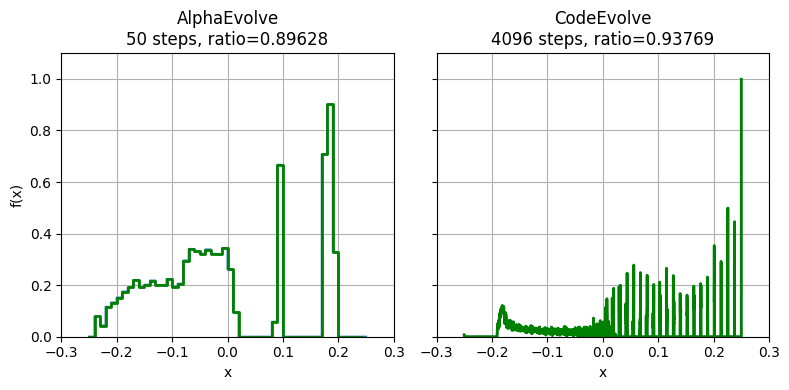

In [5]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#
ae_sol = [
    0.0022217502753395443,
    0.798058737836952,
    0.4369294656327977,
    1.1704958412868685,
    1.3413665690827143,
    1.5342366222696133,
    1.7690742844401723,
    1.9329450122360183,
    2.2225113878900893,
    1.9363966992163675,
    2.0382191032475467,
    2.2010898310433933,
    2.0229605588392388,
    2.029541518023742,
    2.2636974412575626,
    1.9622346498507677,
    2.0781053776466134,
    2.9856571697702514,
    3.4418422600649374,
    3.3477129878607825,
    3.253250196453988,
    3.420135507780267,
    3.2509579118114464,
    3.2308578066681575,
    3.4707132763246245,
    2.6462657430572087,
    0.9614362498214617,
    0,
    0.0008733532713782356,
    0.00041056186458359313,
    0.00029587319086208687,
    5.039012949497012e-06,
    0,
    0.5858888998745988,
    6.741440691998236,
    7.934548956206666e-06,
    0.00013382382526231794,
    4.551621108101551e-06,
    0.0008898629473865954,
    1.083008496291632e-05,
    0.0006121618352774956,
    0.0011493704284828532,
    7.157034681754761,
    9.111886252846807,
    3.3127569806426527,
    8.556232703271356e-06,
    0.00017950056213609822,
    2.7122354902710758e-06,
    1.4036462843158317e-05,
    1.1451768709981007e-05,
]

norm_ae_sol = ae_sol / (1 + np.max(ae_sol))
norm_ce_sol = ce_sol / (1 + np.max(ce_sol))

ae_obj = verify_p1(norm_ae_sol)
ce_obj = verify_p1(norm_ce_sol)
results_df_rows["P1"] = [ae_obj, ce_obj]

plot_two_step_functions(
    norm_ae_sol,
    norm_ce_sol,
    title_1=f"AlphaEvolve\n{len(ae_sol)} steps, ratio={ae_obj:.5f}",
    title_2=f"CodeEvolve\n{len(ce_sol)} steps, ratio={ce_obj:.5f}",
    figsize=(8, 4),
    save_path="figs/P1_results.pdf",
)

### P2

#### P2.A (n = 16, d = 2)

In [6]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def plot_point_configuration(
    points1: np.ndarray,
    points2: np.ndarray,
    figsize=(8, 6),
    name1: str = "Configuration 1",
    name2: str = "Configuration 2",
    save_path=None,
):
    """Plots two 2D point configurations side by side, highlighting closest and furthest pairs."""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    def plot_single_config(points, ax, name):
        """Helper function to plot a single configuration."""
        condensed_distances = sp.spatial.distance.pdist(points)
        min_distance = np.min(condensed_distances)
        max_distance = np.max(condensed_distances)
        ratio = (max_distance / min_distance) ** 2
        distance_matrix = sp.spatial.distance.squareform(condensed_distances)
        max_distance_pairs_indices = np.where(np.isclose(distance_matrix, max_distance))
        min_distance_pairs_indices = np.where(np.isclose(distance_matrix, min_distance))

        ax.scatter(points[:, 0], points[:, 1], color="black", s=100)

        max_plotted = False
        for i_index, j_index in zip(*max_distance_pairs_indices):
            if i_index < j_index:
                ax.plot(
                    [points[i_index, 0], points[j_index, 0]],
                    [points[i_index, 1], points[j_index, 1]],
                    color="red",
                    linewidth=2,
                    label="maximum distance" if not max_plotted else "",
                )
                max_plotted = True

        min_plotted = False
        for i_index, j_index in zip(*min_distance_pairs_indices):
            if i_index < j_index:
                ax.plot(
                    [points[i_index, 0], points[j_index, 0]],
                    [points[i_index, 1], points[j_index, 1]],
                    color="blue",
                    linewidth=2,
                    label="minimum distance" if not min_plotted else "",
                )
                min_plotted = True

        ax.set_title(f"{name}\n{len(points)} points, ratio ~ sqrt({ratio:.6f})")
        ax.axis("off")
        ax.set_aspect("equal", adjustable="box")
        ax.legend(loc="lower right")

        return ratio

    ratio1 = plot_single_config(points1, ax1, name1)
    ratio2 = plot_single_config(points2, ax2, name2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=fig.dpi, bbox_inches="tight")
    plt.show()


def verify_p2(construction):
    print(f"Construction has {len(construction)} points in {construction.shape[1]} dimensions.")
    pairwise_distances = sp.spatial.distance.pdist(construction)
    min_distance = np.min(pairwise_distances)
    max_distance = np.max(pairwise_distances)

    ratio_squared = (max_distance / min_distance) ** 2
    print(f"Ratio of max distance to min distance: sqrt({ratio_squared})")

    return ratio_squared

In [7]:
tgt_exp_name = "gemini_mp_insp_nocontext/"

args = {
    "inpt_dir": "../benchmarks/minimizing_max_min_dist/2/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "min_max_dist_dim2_16",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

Construction has 16 points in 2 dimensions.
Ratio of max distance to min distance: sqrt(12.88926611203463)
Construction has 16 points in 2 dimensions.
Ratio of max distance to min distance: sqrt(12.889237914647687)


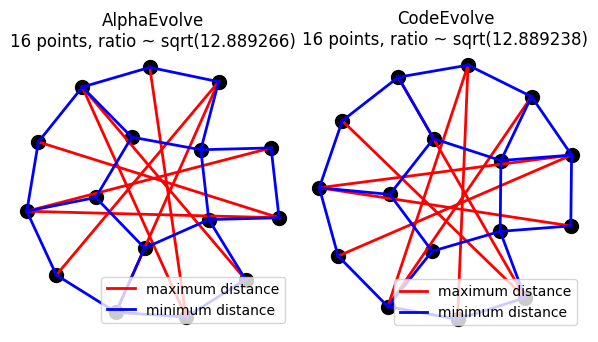

In [8]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#
ae_sol = np.array(
    [
        (0.8470278707092158, 0.2918282514726773),
        (-0.23745459443195124, -0.8571978965568918),
        (0.3557900209463371, 0.279097289488927),
        (-0.8607342601440215, -0.15089717398730187),
        (-0.4726876231254993, 0.7174253632783496),
        (-0.3788383952523786, -0.05470430230958746),
        (-0.03757671392994971, -0.4082819539247519),
        (0.4800129548135765, 0.7545395596986599),
        (-0.000979763279861421, 0.8551512034827423),
        (-0.7797718797834859, 0.33379016991681987),
        (-0.6541792267650747, -0.5967802443605281),
        (0.6682256918291543, -0.6282247082504422),
        (0.9028949024748079, -0.1963885801084583),
        (0.41165705912895084, -0.2091194383890215),
        (0.25280396897954216, -0.8907156599623591),
        (-0.12757658935294616, 0.3676038779372552),
    ]
)

ae_obj = verify_p2(ae_sol)
ce_obj = verify_p2(ce_sol)

results_df_rows["P2.A"] = [ae_obj, ce_obj]


plot_point_configuration(
    ae_sol,
    ce_sol,
    figsize=(6, 4),
    name1="AlphaEvolve",
    name2="CodeEvolve",
    save_path="figs/P2A_results.pdf",
)

#### P2.B (n = 14,d = 3)

In [9]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def plot_point_configuration(
    points1: np.ndarray,
    points2: np.ndarray,
    figsize=(8, 6),
    name1: str = "Configuration 1",
    name2: str = "Configuration 2",
    save_path=None,
):
    """Plots two 3D point configurations side by side, highlighting closest and furthest pairs."""

    fig = plt.figure(figsize=figsize)

    def plot_single_config(points, ax, name):
        """Helper function to plot a single 3D configuration."""
        condensed_distances = sp.spatial.distance.pdist(points)
        min_distance = np.min(condensed_distances)
        max_distance = np.max(condensed_distances)
        ratio = (max_distance / min_distance) ** 2
        distance_matrix = sp.spatial.distance.squareform(condensed_distances)
        max_distance_pairs_indices = np.where(np.isclose(distance_matrix, max_distance))
        min_distance_pairs_indices = np.where(np.isclose(distance_matrix, min_distance))

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="black", s=100)

        max_plotted = False
        for i_index, j_index in zip(*max_distance_pairs_indices):
            if i_index < j_index:
                ax.plot(
                    [points[i_index, 0], points[j_index, 0]],
                    [points[i_index, 1], points[j_index, 1]],
                    [points[i_index, 2], points[j_index, 2]],
                    color="red",
                    linewidth=2,
                    label="maximum distance" if not max_plotted else "",
                )
                max_plotted = True

        min_plotted = False
        for i_index, j_index in zip(*min_distance_pairs_indices):
            if i_index < j_index:
                ax.plot(
                    [points[i_index, 0], points[j_index, 0]],
                    [points[i_index, 1], points[j_index, 1]],
                    [points[i_index, 2], points[j_index, 2]],
                    color="blue",
                    linewidth=2,
                    label="minimum distance" if not min_plotted else "",
                )
                min_plotted = True

        ax.set_title(f"{name}\n{len(points)} points, ratio ~ sqrt({ratio:.6f})")
        ax.set_aspect("equal", adjustable="box")
        ax.legend()

        return ratio

    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection="3d")

    ratio1 = plot_single_config(points1, ax1, name1)
    ratio2 = plot_single_config(points2, ax2, name2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=fig.dpi, bbox_inches="tight")
    plt.show()

In [10]:
tgt_exp_name = "gemini_mp_insp/"

args = {
    "inpt_dir": "../benchmarks/minimizing_max_min_dist/3/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "min_max_dist_dim3_14",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

Construction has 14 points in 3 dimensions.
Ratio of max distance to min distance: sqrt(4.1658497672256525)
Construction has 14 points in 3 dimensions.
Ratio of max distance to min distance: sqrt(4.165788439124644)


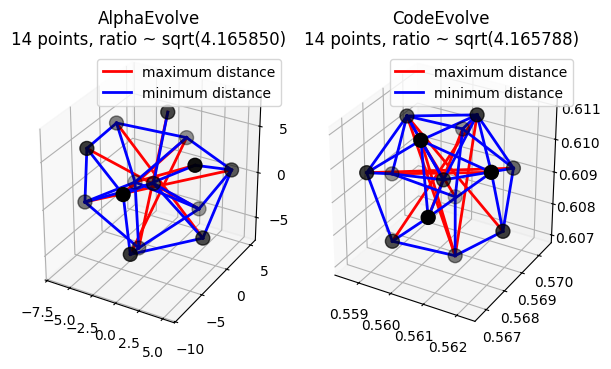

In [11]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

ae_sol = np.array(
    [
        (-5.596123673583122, -5.695471111926107, 4.959047320055149),
        (5.116926601383272, -2.9088174983840958, -2.8844213258624003),
        (-6.606159121469469, 1.1976559300318508, 4.205115060194249),
        (0.33263279200499823, -9.151690403732108, 3.5421854577228027),
        (-0.43984530846509556, 0.2175383405880955, 7.387161767180721),
        (-1.0482338026105975, 5.032254234659363, 2.3318033382908223),
        (0.33760218404299963, -8.010249719722893, -3.371583323549962),
        (4.745850590864617, -3.9828624854138783, 5.248008874626355),
        (-2.144088866983676, -2.3007882626834237, -6.588159606967483),
        (-0.8091020398380586, -1.7732214204952712, 0.6786858286172662),
        (5.334738572382582, 2.1672115465961803, 1.9415133400809574),
        (-6.83950764442355, -4.338724821681177, -1.8023709245292203),
        (-5.346496436622179, 2.4644877336392232, -2.570708726021154),
        (1.5164799724062628, 3.0213278117227174, -3.8718307541919557),
    ]
)

ae_obj = verify_p2(ae_sol)
ce_obj = verify_p2(ce_sol)

results_df_rows["P2.B"] = [ae_obj, ce_obj]

plot_point_configuration(
    ae_sol,
    ce_sol,
    figsize=(6, 5),
    name1="AlphaEvolve",
    name2="CodeEvolve",
    save_path="figs/P2B_results.pdf",
)

### P3

In [12]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def verify_p3(circles: np.ndarray):
    """Checks that the circles are disjoint and lie inside a unit square.

    Args:
      circles: A numpy array of shape (num_circles, 3), where each row is
        of the form (x, y, radius), specifying a circle.

    Raises:
      AssertionError if the circles are not disjoint or do not lie inside the
      unit square.
    """
    # Check pairwise disjointness.
    for circle1, circle2 in itertools.combinations(circles, 2):
        center_distance = np.sqrt(
            (circle1[0] - circle2[0]) ** 2 + (circle1[1] - circle2[1]) ** 2
        )
        radii_sum = circle1[2] + circle2[2]
        assert (
            center_distance >= radii_sum
        ), f"Circles are NOT disjoint: {circle1} and {circle2}."

    # Check all circles lie inside the unit square [0,1]x[0,1].
    for circle in circles:
        assert (
            0 <= min(circle[0], circle[1]) - circle[2]
            and max(circle[0], circle[1]) + circle[2] <= 1
        ), f"Circle {circle} is NOT fully inside the unit square."

    return np.sum(circles[:, -1])


def plot_circles(
    circles1: np.ndarray,
    circles2: np.ndarray,
    label1: str = "Solution 1",
    label2: str = "Solution 2",
    title: str = "",
    figsize=(14, 7),
    save_path=None,
):
    """Plots two circle packing solutions side by side for comparison."""

    def plot_single_solution(circles, ax, solution_label):
        """Helper function to plot a single circle packing solution."""
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect("equal")

        rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor="black", facecolor="none")
        ax.add_patch(rect)

        for circle in circles:
            circ = patches.Circle(
                (circle[0], circle[1]),
                circle[2],
                edgecolor="blue",
                facecolor="skyblue",
                alpha=0.6,
            )
            ax.add_patch(circ)

        total_radius = np.sum(circles[:, 2])

        ax.set_title(
            f"{solution_label}\n{len(circles)} circles, sum of radii = {total_radius:.5f}"
        )

        return total_radius

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    total_radius1 = plot_single_solution(circles1, ax1, label1)
    total_radius2 = plot_single_solution(circles2, ax2, label2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=fig.dpi, bbox_inches="tight")
    plt.show()

#### P3.A (n = 26)

In [13]:
tgt_exp_name = "gemini_mp_insp/"

args = {
    "inpt_dir": "../benchmarks/circle_packing_square/26/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "circle_packing26",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

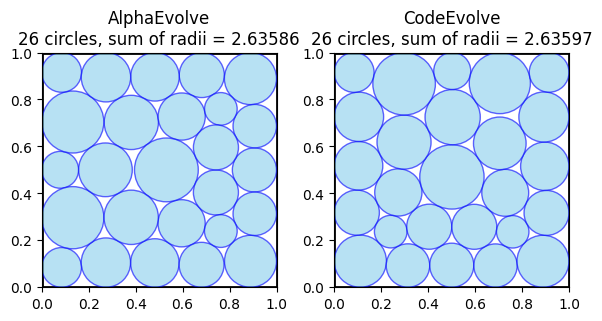

In [14]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

ae_sol = np.array(
    [
        [0.68180423, 0.90401948, 0.09598051040194801],
        [0.90598057, 0.49972596, 0.094019420598057],
        [0.08464495, 0.08464502, 0.084644941535505],
        [0.4818405, 0.1034156, 0.10341558965844],
        [0.48234279, 0.89652324, 0.10347674965232401],
        [0.88928295, 0.11071646, 0.11071644892835401],
        [0.07852351, 0.50033803, 0.07852350214764901],
        [0.27330428, 0.1051224, 0.10512238948776001],
        [0.38153556, 0.70211016, 0.115517618448237],
        [0.13252625, 0.70386646, 0.132047406795258],
        [0.59610341, 0.72720176, 0.10051153994884501],
        [0.59576502, 0.2725969, 0.10054788994521],
        [0.88902242, 0.88902318, 0.11097680890231801],
        [0.68087256, 0.09573004, 0.095730030426996],
        [0.53098174, 0.49996661, 0.13587084641291403],
        [0.90742967, 0.68631006, 0.09257029074297],
        [0.74197859, 0.40386139, 0.095943250405674],
        [0.08471273, 0.91528735, 0.08471263152873601],
        [0.76300349, 0.7598366, 0.069494603050539],
        [0.27358888, 0.89472069, 0.105279299472069],
        [0.13242993, 0.29639184, 0.132426596757339],
        [0.90745313, 0.31316575, 0.092546580745341],
        [0.76284098, 0.23948486, 0.06975189302481001],
        [0.38095848, 0.29797266, 0.115741008425898],
        [0.74207757, 0.59573774, 0.09593309040669],
        [0.27141024, 0.50032568, 0.114361818563817],
    ]
)

ce_sol[:, -1] = np.floor(ce_sol[:, -1] * 1e6) * 1e-6  # round radii

ae_obj = verify_p3(ae_sol)
ce_obj = verify_p3(ce_sol)

results_df_rows["P3.A"] = [ae_obj, ce_obj]

plot_circles(
    ae_sol,
    ce_sol,
    label1="AlphaEvolve",
    label2="CodeEvolve",
    title="Best solution comparison for problem P3.A",
    figsize=(6, 5),
    save_path="figs/P3A_results.pdf",
)

#### P3.B (n = 32)

In [15]:
tgt_exp_name = "gemini_mp_insp/"

args = {
    "inpt_dir": "../benchmarks/circle_packing_square/32/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "circle_packing32",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

prompt_db, sol_db, evolve_state, _ = exp["res"][exp["df"]["best_fitness"].idxmax()].values()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

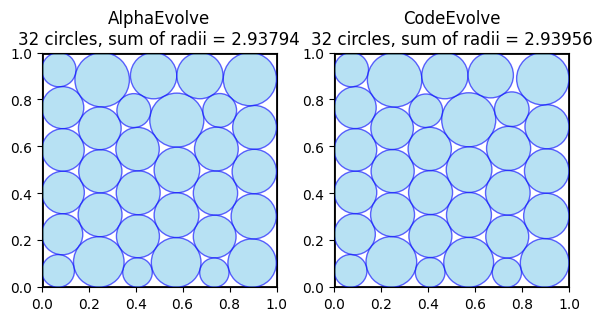

In [16]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

ae_sol = np.array(
    [
        [0.09076163, 0.40381803, 0.090761620923837],
        [0.07310993, 0.92689178, 0.07310821268917801],
        [0.08745017, 0.22570576, 0.087381421261857],
        [0.24855246, 0.30880277, 0.093428060657193],
        [0.4079865, 0.06300614, 0.063006133699386],
        [0.47646318, 0.90136179, 0.09863820013617901],
        [0.89604966, 0.10309934, 0.10309932969006601],
        [0.9066386, 0.68096117, 0.09336139066386],
        [0.08962002, 0.76509474, 0.0895289910471],
        [0.06973669, 0.06965159, 0.06965158303484101],
        [0.40979823, 0.21756451, 0.09156283084371601],
        [0.25742466, 0.88393887, 0.11606111839388701],
        [0.09064689, 0.58506214, 0.090482500951749],
        [0.90294698, 0.30231577, 0.09623644037635501],
        [0.57265603, 0.10585396, 0.105853949414604],
        [0.74007588, 0.40129314, 0.09435083056491601],
        [0.57539962, 0.71183255, 0.115160168483982],
        [0.7367635, 0.21592191, 0.09104997089500201],
        [0.41096972, 0.40263617, 0.093512520648747],
        [0.88664452, 0.88667032, 0.113317128668286],
        [0.57582722, 0.49961748, 0.09705531029446801],
        [0.24962585, 0.49417195, 0.09194421080557799],
        [0.90546338, 0.49309632, 0.094507120549287],
        [0.67381348, 0.90149423, 0.09850576014942301],
        [0.24310147, 0.1077195, 0.10771948922805],
        [0.40815297, 0.5886157, 0.09248833075116601],
        [0.24737889, 0.6771266, 0.090994980900501],
        [0.75801377, 0.7532924, 0.07192969280703],
        [0.73526642, 0.06243992, 0.062439303756069],
        [0.57415412, 0.30715219, 0.095403150459684],
        [0.39239379, 0.75259664, 0.07223814277618501],
        [0.7439361, 0.58879735, 0.093166630683336],
    ]
)

ce_sol[:, -1] = np.floor(ce_sol[:, -1] * 1e6) * 1e-6  # round radii

ae_obj = verify_p3(ae_sol)
ce_obj = verify_p3(ce_sol)

results_df_rows["P3.B"] = [ae_obj, ce_obj]

plot_circles(
    ae_sol,
    ce_sol,
    label1="AlphaEvolve",
    label2="CodeEvolve",
    title="Best solution comparison for problem P3.B",
    figsize=(6, 5),
    save_path="figs/P3B_results.pdf",
)

### P4 (n = 21)

In [17]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def minimum_circumscribing_rectangle(circles: np.ndarray) -> tuple[float, float]:
    """Returns the width and height of the minimum circumscribing rectangle.

    Args:
      circles: A numpy array of shape (num_circles, 3), where each row is of the
        form (x, y, radius), specifying a circle.

    Returns:
      A tuple (width, height) of the minimum circumscribing rectangle.
    """
    min_x = np.min(circles[:, 0] - circles[:, 2])
    max_x = np.max(circles[:, 0] + circles[:, 2])
    min_y = np.min(circles[:, 1] - circles[:, 2])
    max_y = np.max(circles[:, 1] + circles[:, 2])
    return max_x - min_x, max_y - min_y


def verify_circles_disjoint(circles: np.ndarray):
    """Checks that circles are disjoint.

    Args:
      circles: A numpy array of shape (num_circles, 3), where each row is of the
        form (x, y, radius), specifying a circle.

    Raises:
      AssertionError: if the circles are not disjoint.
    """
    for circle1, circle2 in itertools.combinations(circles, 2):
        center_distance = np.sqrt(
            (circle1[0] - circle2[0]) ** 2 + (circle1[1] - circle2[1]) ** 2
        )
        radii_sum = circle1[2] + circle2[2]
        assert (
            center_distance >= radii_sum
        ), f"Circles are NOT disjoint: {circle1} and {circle2}."


def verify_p4(circles):
    num_circles = len(circles)
    verify_circles_disjoint(circles)
    print(f"Construction has {num_circles} disjoint circles.")
    width, height = minimum_circumscribing_rectangle(circles)
    print(f"Perimeter of minimum circumscribing rectangle: {2 * (width + height):.6f}")
    assert (
        width + height
    ) <= 2, "The circles cannot be contained within a rectangle with perimeter 4."
    sum_radii = np.sum(circles[:, 2])
    print("Sum of radii:", sum_radii)

    return sum_radii

In [18]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

def plot_circles_rectangle(
    circles1: np.ndarray,
    circles2: np.ndarray,
    title1: str,
    title2: str,
    figsize: tuple = (14, 7),
    save_path: str = None,
):
    width1, height1 = minimum_circumscribing_rectangle(circles1)
    width2, height2 = minimum_circumscribing_rectangle(circles2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.set_xlim(0, width1)
    ax1.set_ylim(0, height1)
    ax1.set_aspect("equal")

    rect1 = patches.Rectangle(
        (0, 0), width1, height1, linewidth=1, edgecolor="black", facecolor="none"
    )
    ax1.add_patch(rect1)

    for circle in circles1:
        circ = patches.Circle(
            (circle[0], circle[1]),
            circle[2],
            edgecolor="blue",
            facecolor="skyblue",
            alpha=0.5,
        )
        ax1.add_patch(circ)

    ax1.set_title(
        f"{title1}\n{len(circles1)} circles, Perimeter: {round(2 * width1 + 2 * height1, 6)}\nsum of radii = {np.sum(circles1[:,-1]):.5f}"
    )

    ax2.set_xlim(0, width2)
    ax2.set_ylim(0, height2)
    ax2.set_aspect("equal")

    rect2 = patches.Rectangle(
        (0, 0), width2, height2, linewidth=1, edgecolor="black", facecolor="none"
    )
    ax2.add_patch(rect2)

    for circle in circles2:
        circ = patches.Circle(
            (circle[0], circle[1]),
            circle[2],
            edgecolor="blue",
            facecolor="skyblue",
            alpha=0.5,
        )
        ax2.add_patch(circ)

    ax2.set_title(
        f"{title2}\n{len(circles2)} circles, Perimeter: {round(2 * width2 + 2 * height2, 6)}\nsum of radii = {np.sum(circles1[:,-1]):.5f}"
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [19]:
tgt_exp_name = "gemini_mp_insp/"

args = {
    "inpt_dir": "../benchmarks/circle_packing_rect/",
    "out_dirs": [tgt_exp_name],
    "sol_func_name": "circle_packing21",
}

exp = process_experiments(args, model_names, model2cost)[tgt_exp_name]

best_isl = exp["df"]["best_fitness"].idxmax()

tgt_dir = args["inpt_dir"] + "experiments/" + tgt_exp_name
ce_sol = None
if "best_sol.npy" not in os.listdir(tgt_dir):
    sol = get_experiment_sol(
        args["data_dir"] + "results/" + tgt_exp_name, args["sol_func_name"], best_isl
    )
    ce_sol = sol
    np.save(tgt_dir + "best_sol.npy", ce_sol)
else:
    ce_sol = np.load(tgt_dir + "best_sol.npy")

Construction has 21 disjoint circles.
Perimeter of minimum circumscribing rectangle: 4.000000
Sum of radii: 2.3658321334167627
Construction has 21 disjoint circles.
Perimeter of minimum circumscribing rectangle: 4.000000
Sum of radii: 2.3658323670000003


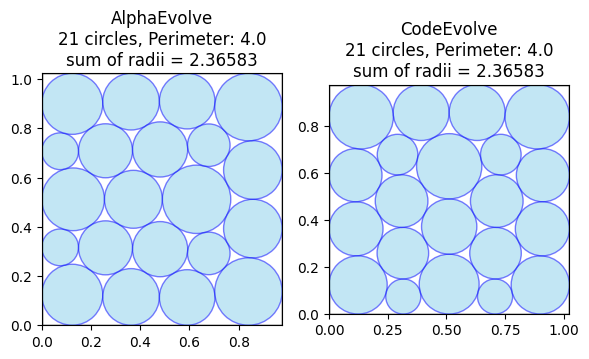

In [20]:
# ===--------------------------------------------------------------------------------------===#
#
# Some of the code in this file is adapted from:
#
# google-deepmind/alphaevolve_results:
# Licensed under the Apache License v2.0.
#
# ===--------------------------------------------------------------------------------------===#

ae_sol = np.array(
    [
        [0.12396161, 0.12396161, 0.12396159760383901],
        [0.0747415, 0.31647214, 0.07474149252585001],
        [0.12740019, 0.51163445, 0.127400177259981],
        [0.0747415, 0.70679675, 0.07474149252585001],
        [0.12396161, 0.89930729, 0.12396159760383901],
        [0.36284141, 0.11508312, 0.115083108491688],
        [0.25916864, 0.31452627, 0.10969588903041],
        [0.37244262, 0.51163445, 0.117642228235776],
        [0.25916864, 0.70874263, 0.10969588903041],
        [0.3628414, 0.90818577, 0.11508311849168701],
        [0.59083599, 0.11292169, 0.11292167870783101],
        [0.48083152, 0.30914434, 0.112032298796769],
        [0.62891008, 0.51163445, 0.138825206117478],
        [0.48083152, 0.71412455, 0.112032298796769],
        [0.59083598, 0.9103472, 0.11292168870783001],
        [0.67852787, 0.2919303, 0.086412051358794],
        [0.85766825, 0.39257159, 0.11906284809371401],
        [0.85766825, 0.6306973, 0.11906284809371401],
        [0.67852787, 0.73133859, 0.086412051358794],
        [0.83965981, 0.8861976, 0.13707128629287002],
        [0.83965981, 0.1370713, 0.13707128629287002],
    ]
)

ce_sol[:, -1] = np.floor(ce_sol[:, -1] * 1e9) * 1e-9  # round radii

ae_obj = verify_p4(ae_sol)
ce_obj = verify_p4(ce_sol)

results_df_rows["P4"] = [ae_obj, ce_obj]

plot_circles_rectangle(
    ae_sol,
    ce_sol,
    title1="AlphaEvolve",
    title2="CodeEvolve",
    figsize=(6, 5),
    save_path="figs/P4_results.pdf",
)

### Results table

In [21]:
results_df = pd.DataFrame.from_dict(
    results_df_rows, orient="index", columns=["AlphaEvolve", "CodeEvolve"]
)

results_df

,AlphaEvolve,CodeEvolve
P1,0.896280,0.937686
P2.A,12.889266,12.889238
P2.B,4.165850,4.165788
P3.A,2.635863,2.635973
P3.B,2.937945,2.939559
P4,2.365832,2.365832
